# Classification

In this lab, we will be building and evaluating different classifiers for recognising handwritten digits of MNIST dataset. We will be doing the following:

1. Binary Classification of MNIST Dataset

In the first set of tasks, you will evaluate a number of popular classifiers for the task of recognizing handwritten digits from MNIST dataset. Specifically, we will focus on distinguishing between 7 and 9 which are known to be a hard pair. 

2. Exploration of Different Evaluation Metrics. 

In the second set of tasks, you will learn how (and when) to use evaluation metrics for classifiers.

3. Parameter Tuning through Grid Search/Cross Validation and Parallelization.

You will learn how to tune your classifier and find optimal parameters using grid search. This is a very computationally intensive task - so you will also explore how to leverage parallelization capabilities of IPython kernel to get results sooner.

In [1]:
%matplotlib inline 

#Array processing
import numpy as np

#Data analysis, wrangling and common exploratory operations
import pandas as pd
from pandas import Series, DataFrame

#For visualization. Matplotlib for basic viz and seaborn for more stylish figures + statistical figures not in MPL.
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import Image

from sklearn.datasets import fetch_mldata                                                                       
from sklearn.utils import shuffle                                                                                   
from sklearn import metrics                                                                                                  
from sklearn import tree                                                                                                     
from sklearn.tree import DecisionTreeClassifier                                                       
from sklearn.naive_bayes import MultinomialNB  
from sklearn.linear_model import LogisticRegression                                            
from sklearn.ensemble import RandomForestClassifier                                                                                                          
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV                                                
from sklearn.preprocessing import StandardScaler

import pydot, io
import time

#######################End imports###################################


/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Part 1: Binary Classification of MNIST Dataset

In the first set of tasks, you will evaluate a number of popular classifiers for the task of recognizing handwritten digits from MNIST dataset. Specifically, we will focus on distinguishing between 7 and 9 which are known to be a hard pair.

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


#Images = 70000 and #Pixel per image = 784
First image shows 0
The corresponding matrix version of image is 
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  51 159 253 159  50   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252
 253 122   0  

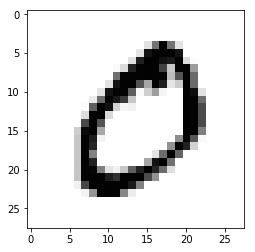

In [2]:
####################Do not change anything below
#Load MNIST data. fetch_mldata will download the dataset and put it in a folder called mldata. 
#Some things to be aware of:
#   The folder mldata will be created in the folder in which you started the notebook
#   So to make your life easy, always start IPython notebook from same folder.
#   Else the following code will keep downloading MNIST data
mnist = fetch_mldata("MNIST original")                      
#The data is organized as follows:
#  Each row corresponds to an image
#  Each image has 28*28 pixels which is then linearized to a vector of size 784 (ie. 28*28)
# mnist.data gives the image information while mnist.target gives the number in the image
print("#Images = %d and #Pixel per image = %s" % (mnist.data.shape[0], mnist.data.shape[1]))

#Print first row of the dataset 
img = mnist.data[0]                                                                                                          
print("First image shows %d" % (mnist.target[0]))
print("The corresponding matrix version of image is \n" , img)
print("The image in grey shape is ")
plt.imshow(img.reshape(28, 28), cmap="Greys")                                                                                
                                                                                                                             
#First 60K images are for training and last 10K are for testing
all_train_data = mnist.data[:60000]                                                                                          
all_test_data = mnist.data[60000:]                                                                                           
all_train_labels = mnist.target[:60000]                                                                                      
all_test_labels = mnist.target[60000:]                                                                                       
                                                              
                                                                                                                             
#For the first task, we will be doing binary classification and focus  on two pairs of 
#  numbers: 7 and 9 which are known to be hard to distinguish
#Get all the seven images
sevens_data = mnist.data[mnist.target==7]      
#Get all the nine images
nines_data = mnist.data[mnist.target==9]       
#Merge them to create a new dataset
binary_class_data = np.vstack([sevens_data, nines_data])    
binary_class_labels = np.hstack([np.repeat(7, sevens_data.shape[0]), np.repeat(9, nines_data.shape[0])])    
 
#In order to make the experiments repeatable, we will seed the random number generator to a known value
# That way the results of the experiments will always be same
np.random.seed(1234)                        
#randomly shuffle the data
binary_class_data, binary_class_labels = shuffle(binary_class_data, binary_class_labels)  
print("Shape of data and labels are :" , binary_class_data.shape, binary_class_labels.shape)  

#There are approximately 14K images of 7 and 9. 
#Let us take the first 5000 as training and remaining as test data                                          
orig_binary_class_training_data = binary_class_data[:5000]                                                  
binary_class_training_labels = binary_class_labels[:5000]                                                   
orig_binary_class_testing_data = binary_class_data[5000:]                                                   
binary_class_testing_labels = binary_class_labels[5000:] 

#The images are in grey scale where each number is between 0 to 255
# Now let us normalize them so that the values are between 0 and 1. 
# This will be the only modification we will make to the image
binary_class_training_data = orig_binary_class_training_data / 255.0                                        
binary_class_testing_data = orig_binary_class_testing_data / 255.0                                          
scaled_training_data = all_train_data / 255.0                                                                                
scaled_testing_data = all_test_data / 255.0  

print(binary_class_training_data[0,:])                                                                 
     
###########Make sure that you remember the variable names and their meaning
#binary_class_training_data, binary_class_training_labels: Normalized images of 7 and 9 and the correct labels for training
#binary_class_testing_data, binary_class_testing_labels : Normalized images of 7 and 9 and correct labels for testing
#orig_binary_class_training_data, orig_binary_class_testing_data: Unnormalized images of 7 and 9
#all_train_data, all_test_data: un normalized images of all digits 
#all_train_labels, all_test_labels: labels for all digits
#scaled_training_data, scaled_testing_data: Normalized version of all_train_data, all_test_data for all digits


## Binary Classification in scikit-learn

All classifiers in scikit-learn follow a common pattern that makes life much easier. 
Follow these steps for all the tasks below.

1. Instantiate the classifier with appropriate parameters
2. Train/fit the classifier with training data and correct labels
3. Test the classifier with unseen data
4. Evaluate the performance of classifier

### Exercise 1: Decision Trees (10 marks)

In the first task, you will use Decision trees (see url
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
) for classification. 

Implement a CART decision tree with splitting criterion as entropy. Also print the learned decision tree using the supplied function "plot_tree" below.

In [3]:
###Do not make any change below
def plot_dtree(model,fileName):                                                                                              
    #You would have to install a Python package pydot                                                                        
    #You would also have to install graphviz for your system - see http://www.graphviz.org/Download..php                     
    #If you get any pydot error, see url
    # http://stackoverflow.com/questions/15951748/pydot-and-graphviz-error-couldnt-import-dot-parser-loading-of-dot-files-will
    dot_tree_data = io.StringIO()                                                                                      
    tree.export_graphviz(model, out_file = dot_tree_data)                                                                   
    (dtree_graph,) = pydot.graph_from_dot_data(dot_tree_data.getvalue())                                                        
    dtree_graph.write_png(fileName)                   

In [4]:
# Exercise 1 (10 marks)
# Create a CART decision tree with splitting criterion as entropy
# Remember to set the random state to 1234

RANDOM_STATE = 1234

cart = DecisionTreeClassifier(random_state = RANDOM_STATE, criterion = 'entropy').fit(binary_class_training_data, binary_class_training_labels)


In [5]:
cart_predictions = cart.predict(binary_class_testing_data)

# Accuracy checker
print("The prediction accuracy is: ", cart.score(binary_class_testing_data, binary_class_testing_labels)*100,"%")

The prediction accuracy is:  96.94087125716139 %


# Save the decision tree as .png image

The image saving is not working on my personal machines so it'll only run on other machines (DCS machines).

In [6]:
import getpass
username = getpass.getuser()

print(username)

if username is "ArghaWin10":
    plot_dtree(cart, "tree.png")

arghasarkar


### Exercise 2: Naive Bayes (10 marks)

In this task, you will create a multinomial Naive Bayes classifiers and evaluate it. 

You might want to use the following url
http://scikit-learn.org/stable/modules/naive_bayes.html 

In [7]:
# Exercise 2 (10 marks)
# Create multinomial NB
mnb = MultinomialNB()

mnb_model = mnb.fit(binary_class_training_data, binary_class_training_labels)

In [8]:
mnb_predictions = mnb_model.predict(binary_class_testing_data)

print("The prediction accuracy is: ", mnb_model.score(binary_class_testing_data, binary_class_testing_labels)*100,"%")

The prediction accuracy is:  91.59009836774403 %


### Exercise 3: Logistic Regression (10 marks)

Logistic regression is a simple classifier that converts a regression model into a classification one.
You can read the details at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 


In [9]:
# Exercise 3 (10 marks)
# Create a model with default parameters. Remember to set random state to 1234
lgr = LogisticRegression(random_state = RANDOM_STATE, solver = "lbfgs", multi_class="multinomial")

lgr_model = lgr.fit(binary_class_training_data, binary_class_training_labels)


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [10]:
lgr_predictions = lgr_model.predict(binary_class_testing_data)

print("The prediction accuracy is: ", lgr_model.score(binary_class_testing_data, binary_class_testing_labels)*100,"%")

The prediction accuracy is:  95.6653334774619 %


### Exercise 4: Random Forests (10 marks)

Random Forests is a very popular ensemble method. See url 
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
for details. Implement a Random Forest (10 marks)

In [11]:
# Exercise 4 (10 marks)
# Create a random forest classifier with Default parameters

# clf = RandomForestClassifier(n_estimators=1000, max_depth=12,
#                              random_state=RANDOM_STATE)

clf = RandomForestClassifier()

clf_model = clf.fit(binary_class_training_data, binary_class_training_labels)


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [12]:
clf_predictions = clf_model.predict(binary_class_testing_data)

print("The prediction accuracy is: ", clf_model.score(binary_class_testing_data, binary_class_testing_labels)*100,"%")

The prediction accuracy is:  97.54621122040861 %


## Part 2: Exploration of Different Evaluation Metrics for Binary Classification

Let us evaluate different metrics for the binary classification models that we created so far. 
You may want to check the url http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics for additional details.

### Exercise 5: Print the classification results (total: 20 marks)

For each of the models above:

- Task 5a: Print the classification report and confusion matrix (5 marks)
- Task 5b: Print the ROC curve (5 marks)
- Task 5c: Print the AUC curve (5 marks)
- Task 5d: Print the precision/recall curve (5 marks)

In [13]:
# task t5a (5 marks)
# Print the classification report and confusion matrix for each of the models above
# Write code here
from sklearn.metrics import classification_report, confusion_matrix


'''
    Classification report for CART decision tree
'''
print("Classification report for CART:")
print(classification_report(binary_class_testing_labels, cart_predictions))
print("Confusion matrix:")
print(confusion_matrix(binary_class_testing_labels, cart_predictions))

'''
    Classification report for Multinomial Naive Bayes
'''
print("\n\nClassification report for Multinomial Naive Bayes:")
print(classification_report(binary_class_testing_labels, mnb_predictions))
print("Confusion matrix:")
print(confusion_matrix(binary_class_testing_labels, mnb_predictions))

'''
    Classification report for Logistic Regression
'''
print("\n\nClassification report for Logistic Regression:")
print(classification_report(binary_class_testing_labels, lgr_predictions))
print("Confusion matrix:")
print(confusion_matrix(binary_class_testing_labels, lgr_predictions))

'''
    Classification report for Random Forest with default parameters
'''
print("\n\nClassification report for Logistic Regression:")
print(classification_report(binary_class_testing_labels, clf_predictions))
print("Confusion matrix:")
print(confusion_matrix(binary_class_testing_labels, lgr_predictions))


Classification report for CART:
              precision    recall  f1-score   support

           7       0.97      0.97      0.97      4746
           9       0.96      0.97      0.97      4505

   micro avg       0.97      0.97      0.97      9251
   macro avg       0.97      0.97      0.97      9251
weighted avg       0.97      0.97      0.97      9251

Confusion matrix:
[[4584  162]
 [ 121 4384]]


Classification report for Multinomial Naive Bayes:
              precision    recall  f1-score   support

           7       0.95      0.88      0.91      4746
           9       0.88      0.95      0.92      4505

   micro avg       0.92      0.92      0.92      9251
   macro avg       0.92      0.92      0.92      9251
weighted avg       0.92      0.92      0.92      9251

Confusion matrix:
[[4174  572]
 [ 206 4299]]


Classification report for Logistic Regression:
              precision    recall  f1-score   support

           7       0.96      0.96      0.96      4746
           9 

# Convert 7 & 9 predictions to binary classifications

For calculating the ROC curve, binary information needs to be given. However, the predictions are multi-class predictions for **7** and **9**. This needs to be converted into two separate binary classifications, one for 7 and the other for 9. These two arrays will contain 0's and 1's indicating if the prediction is correct. 

This has been done using the ```label_binarize``` function.

In [14]:
# task t5b (5 marks)
# Each of the model above has some probabilistic interpretation
# So sklearn allows you to get the probability values as part of classification
# Using this information, you can print roc_curve
# See http://nbviewer.ipython.org/github/datadave/GADS9-NYC-Spring2014-Lectures/blob/master/lessons/lesson09_decision_trees_random_forests/sklearn_decision_trees.ipynb
# Write code here

from sklearn.preprocessing import label_binarize

# The class labels being used
CLASS_LABELS = [7, 9]

# Binarizing the testing labels
binarized_testing_labels = label_binarize(binary_class_testing_labels, classes = CLASS_LABELS)

# Binarizing the CART predictions
binarized_cart_preds = label_binarize(cart_predictions, classes = CLASS_LABELS)

# Binarizing the Multinomial Naive Bayes predictions
binarized_mnb_preds = label_binarize(mnb_predictions, classes = CLASS_LABELS)

# Binarizing the Logistic Regression predictions
binarized_lgr_preds = label_binarize(lgr_predictions, classes = CLASS_LABELS)

# Binarizing the Random Forest predictions
binarized_clf_preds = label_binarize(clf_predictions, classes = CLASS_LABELS)


Now that the binarization of the labels have been done, calculate the ROC curve and plot it.

The function ```plot_roc``` takes the **binarized labels** and the **binarized predictions** as the main input paramters which are required for getting the ROC statistics. It also takes the name of the classifier as string for adding the title. The plot is returned by the function.

Figure(720x288)
Figure(720x288)
Figure(720x288)
Figure(720x288)


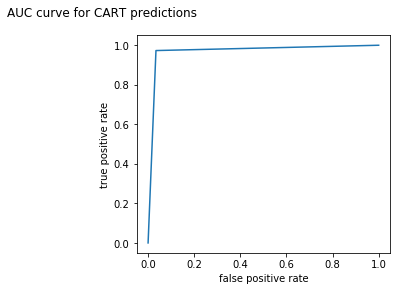

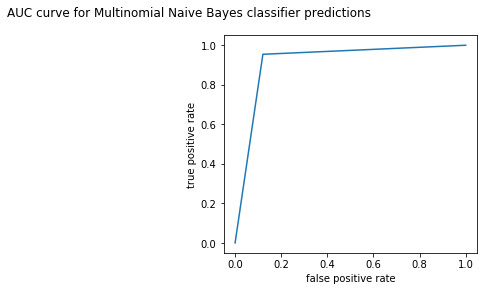

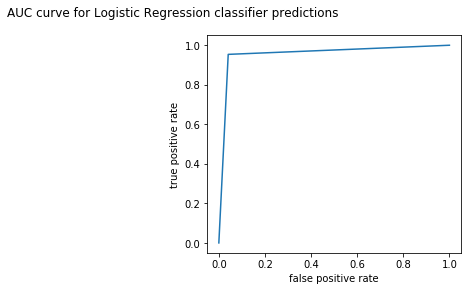

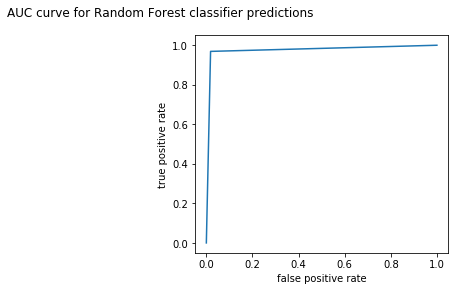

In [15]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

def plot_auc(labels, predictions, classifier_name=None):
    
    title = "AUC curve"
    if classifier_name is not None:
        title = "AUC curve for {} predictions".format(classifier_name)
    
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.suptitle(title)

    cart_plot = plt.subplot(1, 2, 2)
    cart_plot.set_xlabel('false positive rate')
    cart_plot.set_ylabel('true positive rate')
    cart_plot.plot(fpr, tpr)
    
    return fig
    

# Plot the AUC curve for CART
print(plot_auc(binarized_testing_labels, binarized_cart_preds, "CART"))

# Plot the AUC curve for Multinomial Naive Bayes classifier
print(plot_auc(binarized_testing_labels, binarized_mnb_preds, "Multinomial Naive Bayes classifier"))
    
# Plot the AUC curve for Logistic Regression classifier
print(plot_auc(binarized_testing_labels, binarized_lgr_preds, "Logistic Regression classifier"))

# Plot the AUC curve for Random forests classifier
print(plot_auc(binarized_testing_labels, binarized_clf_preds, "Random Forest classifier"))


In [16]:
# task t5c (5 marks)
# Print the AUC value for each of the models above
# Write code here


AxesSubplot(0.547727,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)
AxesSubplot(0.547727,0.125;0.352273x0.755)


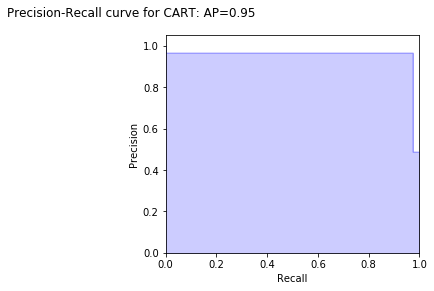

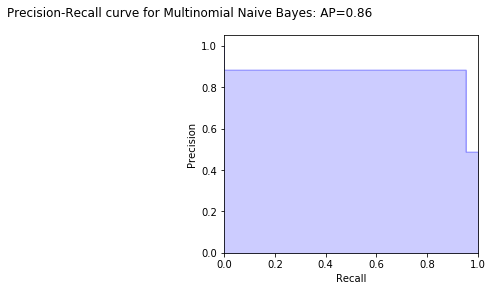

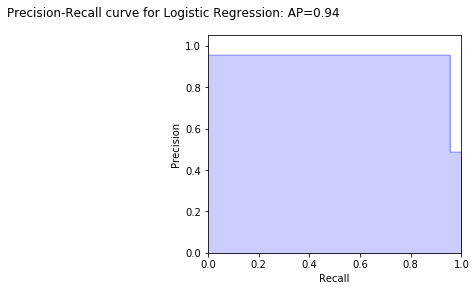

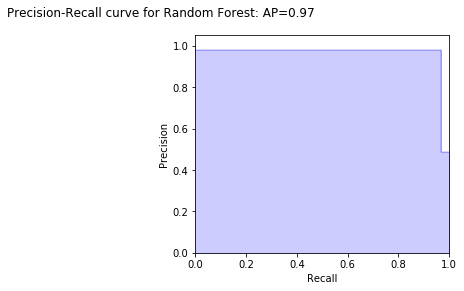

In [59]:
# task t5d (5 marks)
# Print the precision recall curve for each of the models above
# print the curve based on http://scikit-learn.org/stable/auto_examples/plot_precision_recall.html   
# Write code here

from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score


def plot_precision_recall_curve(labels, predictions, classifier_name=None):
    
    title = "Precision-Recall curve"
    if classifier_name is not None:
        title = "Precision-Recall curve for {} predictions".format(classifier_name)
        
    precision, recall, thresholds = precision_recall_curve(labels, predictions)
    
    average_precision = average_precision_score(labels, predictions)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.suptitle('Precision-Recall curve for {0}: AP={1:0.2f}'.format(classifier_name, average_precision))
    
    plot = plt.subplot(1, 2, 2)
    
    plot.step(recall, precision, color='b', alpha=0.2, where='post')
    
    plot.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plot.set_xlabel('Recall')
    plot.set_ylabel('Precision')
    plot.set_ylim([0.0, 1.05])
    plot.set_xlim([0.0, 1.0])
    
    
    return plot

# Plot the precision-recall curve for CART
print(plot_precision_recall_curve(binarized_testing_labels, binarized_cart_preds, "CART"))

# Plot the precision-recall curve for Multinomial Naive Bayes
print(plot_precision_recall_curve(binarized_testing_labels, binarized_mnb_preds, "Multinomial Naive Bayes"))

# Plot the precision-recall curve for Logistic Regression
print(plot_precision_recall_curve(binarized_testing_labels, binarized_lgr_preds, "Logistic Regression"))

# Plot the precision-recall curve for Random Forest
print(plot_precision_recall_curve(binarized_testing_labels, binarized_clf_preds, "Random Forest"))

## Part 3: Parameter Tuning through Grid Search/Cross Validation and Parallelization

So far in this assignment, you manually tweaked the model till it became better.
For complex models, this is often cumbersome. A common trick people use is called Grid Search where you exhaustively test various parameter combinations
and pick the best set of parameter values. This is a VERY computationally intensive process and hence it will require some parallelization.

In this part, you will learn how to tune Randm Forest for MNIST dataset
and then parallelize it so as to get results faster.
You might want to take a look at the url
http://scikit-learn.org/stable/modules/grid_search.html
for additional details.

One thing you might want to note is that the GridSearchCV uses cross validation for comparing models.

So you have to send the ENTIRE MNIST dataset - i.e. mnist.data and mnist.target. 

The following cell creates two variables all_scaled_data and all_scaled_target that you can pass to GridSearchCV.

In order to get the results in reasonable time, set the **cv** parameter of GridSearchCV to 3.
Also remember to set the **verbose** parameter to 2 to get some details about what happens internally.

In [18]:
###Do not make any change below
all_scaled_data = binary_class_data / 255.0
all_scaled_target = binary_class_labels

### Exercise 6: Tuning parameters for Random Forest using grid search (15 marks)

In [19]:
# Exercise 6 (15 marks)
# Tuning Random Forest for MNIST
tuned_parameters = [{'max_features': ['sqrt', 'log2'], 'n_estimators': [1000, 1500]}] 

# Write code here

# print the details of the best model and its accuracy
# Write code here